Stock Data Collection

In [42]:
import pandas as pd
import numpy as np
import pandas_datareader as pdr
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [43]:
#Data Collection

df = pdr.DataReader('AAPL', data_source='yahoo', start='2012-01-01', end='2020-12-31')
df.to_csv('AAPL.csv')

In [44]:
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-01-03,14.732143,14.607143,14.621429,14.686786,302220800.0,12.591937
2012-01-04,14.810000,14.617143,14.642857,14.765714,260022000.0,12.659613
2012-01-05,14.948214,14.738214,14.819643,14.929643,271269600.0,12.800154
2012-01-06,15.098214,14.972143,14.991786,15.085714,318292800.0,12.933965
2012-01-09,15.276786,15.048214,15.196429,15.061786,394024400.0,12.913448
...,...,...,...,...,...,...
2020-12-24,133.460007,131.100006,131.320007,131.970001,54930100.0,131.161423
2020-12-28,137.339996,133.509995,133.990005,136.690002,124486200.0,135.852509
2020-12-29,138.789993,134.339996,138.050003,134.869995,121047300.0,134.043655


In [83]:
#Taking the cosing price

df_close = df.reset_index()['Close']
df_close

0        14.686786
1        14.765714
2        14.929643
3        15.085714
4        15.061786
           ...    
2260    131.970001
2261    136.690002
2262    134.869995
2263    133.720001
2264    132.690002
Name: Close, Length: 2265, dtype: float64

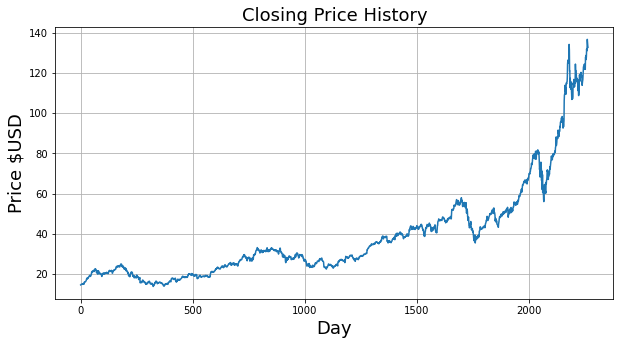

In [46]:
#Ploting the closing price of stock

plt.figure(figsize=(10,5))
plt.title("Closing Price History", fontsize=18)
plt.xlabel('Day', fontsize=18)
plt.ylabel('Price $USD', fontsize=18)
plt.plot(df_close)
plt.grid()

In [47]:
df_close

0        14.686786
1        14.765714
2        14.929643
3        15.085714
4        15.061786
           ...    
2260    131.970001
2261    136.690002
2262    134.869995
2263    133.720001
2264    132.690002
Name: Close, Length: 2265, dtype: float64

In [48]:
# Scaling the data with MinMax Scaler as LSTM is sensitive to the scale of data.

scaler = MinMaxScaler(feature_range=(0,1)) #data will range between 0 and 1
df_close = scaler.fit_transform(np.array(df_close).reshape(-1,1))

In [49]:
df_close #Normalized dataset

array([[0.00602306],
       [0.0066661 ],
       [0.00800165],
       ...,
       [0.98517215],
       [0.97580299],
       [0.96741145]])

In [50]:
# Splitting the traing and testing dataset

training_size = int(len(df_close)*0.7)
test_size = len(df_close) - training_size
train_data = df_close[0:training_size,:]  #Appending all traing data into an array
test_data = df_close[training_size:len(df_close),:]  #Appending all testing data into an array

In [51]:
# Preprocessing the data

def create_dataset (dataset, time_step = 1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step):
        a = dataset[i:(i+time_step), 0] 
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [52]:
# Reshaping data into X = t, t+1, t+2 and Y = t+4

time_step = 100
x_train, y_train = create_dataset(train_data, time_step)
x_test, y_test = create_dataset(test_data, time_step)

In [53]:
# Reshaping the input dataset in 3D array for LSTM

x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

In [54]:
# Creating stacked LSTM model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [55]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100, 1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [56]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 100, 50)           10400     
                                                                 
 lstm_4 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_5 (LSTM)               (None, 50)                20200     
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [57]:
model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=100, batch_size=64, verbose=1)

Epoch 1/100
24/24 [==============================] - 15s 201ms/step - loss: 0.0024 - val_loss: 0.0148
Epoch 2/100
24/24 [==============================] - 4s 151ms/step - loss: 2.6748e-04 - val_loss: 0.0035
Epoch 3/100
24/24 [==============================] - 4s 151ms/step - loss: 1.2242e-04 - val_loss: 0.0040
Epoch 4/100
24/24 [==============================] - 4s 151ms/step - loss: 9.7561e-05 - val_loss: 0.0032
Epoch 5/100
24/24 [==============================] - 4s 151ms/step - loss: 9.4694e-05 - val_loss: 0.0039
Epoch 6/100
24/24 [==============================] - 4s 152ms/step - loss: 9.4908e-05 - val_loss: 0.0036
Epoch 7/100
24/24 [==============================] - 4s 157ms/step - loss: 9.3020e-05 - val_loss: 0.0031
Epoch 8/100
24/24 [==============================] - 4s 153ms/step - loss: 9.5734e-05 - val_loss: 0.0035
Epoch 9/100
24/24 [==============================] - 4s 152ms/step - loss: 9.6731e-05 - val_loss: 0.0024
Epoch 10/100
24/24 [==============================] - 4s 1

24/24 [==============================] - 4s 152ms/step - loss: 2.9328e-05 - val_loss: 9.9573e-04
Epoch 78/100
24/24 [==============================] - 4s 152ms/step - loss: 2.7862e-05 - val_loss: 4.0160e-04
Epoch 79/100
24/24 [==============================] - 4s 158ms/step - loss: 2.7405e-05 - val_loss: 4.4885e-04
Epoch 80/100
24/24 [==============================] - 4s 152ms/step - loss: 2.6262e-05 - val_loss: 9.7115e-04
Epoch 81/100
24/24 [==============================] - 4s 152ms/step - loss: 2.6969e-05 - val_loss: 5.9138e-04
Epoch 82/100
24/24 [==============================] - 4s 153ms/step - loss: 2.7559e-05 - val_loss: 5.7188e-04
Epoch 83/100
24/24 [==============================] - 4s 162ms/step - loss: 2.6060e-05 - val_loss: 6.2645e-04
Epoch 84/100
24/24 [==============================] - 4s 152ms/step - loss: 2.5861e-05 - val_loss: 8.5451e-04
Epoch 85/100
24/24 [==============================] - 4s 153ms/step - loss: 2.4561e-05 - val_loss: 0.0011
Epoch 86/100
24/24 [=======

In [58]:
import tensorflow as tf

In [59]:
# Predicting and checking performance metrics

train_predict = model.predict(x_train)
test_predict = model.predict(x_test)

In [60]:
# Reverse scaling the data

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [61]:
# Calculating Root Mean Square Error(RMSE) performance metrics

import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train, train_predict))

28.173917008116003

In [62]:
# Test data RMSE 

math.sqrt(mean_squared_error(y_test, test_predict))

74.36434017325668

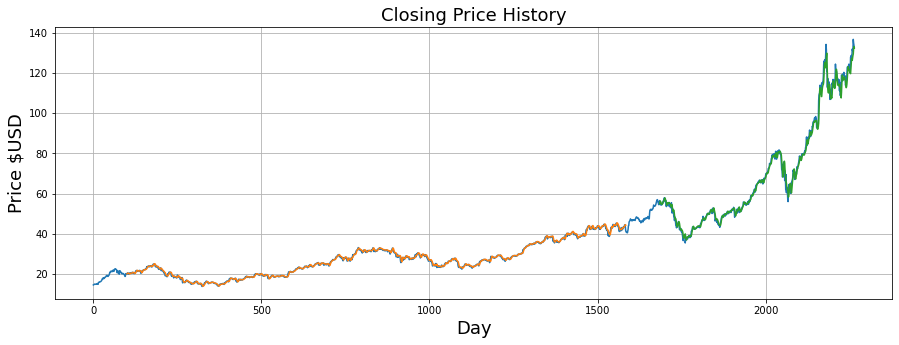

In [63]:
# Plotting the data

# Train prediction for plotting
look_back = 100
trainPredictPlot = np.empty_like(df_close)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict

# Test Prediction for plotting
testPredictPlot = np.empty_like(df_close)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2):len(df_close), :] = test_predict

# Plotting baselinr and prediction
plt.figure(figsize=(15,5))
plt.title("Closing Price History", fontsize=18)
plt.xlabel('Day', fontsize=18)
plt.ylabel('Price $USD', fontsize=18)
plt.plot(scaler.inverse_transform(df_close))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.grid()
plt.show()

In [64]:
len(test_data)

680

In [65]:
x_input = test_data[580:].reshape(1,-1)
x_input.shape

(1, 100)

In [66]:
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

In [67]:
# Next 30 day prediction

from numpy import array

list_output = []
n_steps  = 100
i=0
while(i<30):
    if(len(temp_input)>100):
        x_input=np.array(temp_input[1:])
        print('{} day input {}'.format(i, x_input))
        x_input = x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print('{} day input {}'.format(i, yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input= temp_input[1:]
        list_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        list_output.extend(yhat.tolist())
        i=i+1
print(list_output)

[0.95175767]
101
1 day input [0.80707579 0.82337006 0.82253498 0.82009081 0.82787134 0.82905265
 0.84997046 0.89962727 0.9117461  0.90333417 0.91716396 0.90484144
 0.90319165 0.93767433 0.97955061 0.95690157 0.87119372 0.87184551
 0.80552781 0.84218993 0.81098638 0.79884716 0.82622155 0.82768804
 0.79990627 0.78532289 0.75680791 0.78320468 0.79729919 0.75908916
 0.768051   0.80112835 0.82296268 0.81587465 0.82988774 0.83787196
 0.80715722 0.83550928 0.80829787 0.82394036 0.82304417 0.83933845
 0.89987168 0.8729861  0.87371937 0.86980872 0.85604004 0.8312728
 0.84373791 0.83852374 0.82939893 0.82361447 0.82369596 0.83632398
 0.79232943 0.82589566 0.77326516 0.77253188 0.78613765 0.82288119
 0.85612153 0.85335153 0.83404279 0.83119131 0.8598692  0.85758802
 0.8579954  0.86646843 0.8590545  0.84797439 0.85294415 0.84235285
 0.81391936 0.82467357 0.83168012 0.83624249 0.85628451 0.88618448
 0.88911746 0.88797686 0.88235532 0.89457603 0.8997087  0.87852616
 0.89042097 0.88365889 0.87852616 

8 day input [[0.8166357]]
9 day input [0.9117461  0.90333417 0.91716396 0.90484144 0.90319165 0.93767433
 0.97955061 0.95690157 0.87119372 0.87184551 0.80552781 0.84218993
 0.81098638 0.79884716 0.82622155 0.82768804 0.79990627 0.78532289
 0.75680791 0.78320468 0.79729919 0.75908916 0.768051   0.80112835
 0.82296268 0.81587465 0.82988774 0.83787196 0.80715722 0.83550928
 0.80829787 0.82394036 0.82304417 0.83933845 0.89987168 0.8729861
 0.87371937 0.86980872 0.85604004 0.8312728  0.84373791 0.83852374
 0.82939893 0.82361447 0.82369596 0.83632398 0.79232943 0.82589566
 0.77326516 0.77253188 0.78613765 0.82288119 0.85612153 0.85335153
 0.83404279 0.83119131 0.8598692  0.85758802 0.8579954  0.86646843
 0.8590545  0.84797439 0.85294415 0.84235285 0.81391936 0.82467357
 0.83168012 0.83624249 0.85628451 0.88618448 0.88911746 0.88797686
 0.88235532 0.89457603 0.8997087  0.87852616 0.89042097 0.88365889
 0.87852616 0.92822368 0.92765338 0.93490433 0.91828422 0.93107516
 0.96081229 0.95331694 0.

16 day input [[0.78243446]]
17 day input [0.87119372 0.87184551 0.80552781 0.84218993 0.81098638 0.79884716
 0.82622155 0.82768804 0.79990627 0.78532289 0.75680791 0.78320468
 0.79729919 0.75908916 0.768051   0.80112835 0.82296268 0.81587465
 0.82988774 0.83787196 0.80715722 0.83550928 0.80829787 0.82394036
 0.82304417 0.83933845 0.89987168 0.8729861  0.87371937 0.86980872
 0.85604004 0.8312728  0.84373791 0.83852374 0.82939893 0.82361447
 0.82369596 0.83632398 0.79232943 0.82589566 0.77326516 0.77253188
 0.78613765 0.82288119 0.85612153 0.85335153 0.83404279 0.83119131
 0.8598692  0.85758802 0.8579954  0.86646843 0.8590545  0.84797439
 0.85294415 0.84235285 0.81391936 0.82467357 0.83168012 0.83624249
 0.85628451 0.88618448 0.88911746 0.88797686 0.88235532 0.89457603
 0.8997087  0.87852616 0.89042097 0.88365889 0.87852616 0.92822368
 0.92765338 0.93490433 0.91828422 0.93107516 0.96081229 0.95331694
 0.9615455  1.         0.98517215 0.97580299 0.96741145 0.95175767
 0.93368769 0.9137073

27 day input [[0.73635566]]
28 day input [0.78320468 0.79729919 0.75908916 0.768051   0.80112835 0.82296268
 0.81587465 0.82988774 0.83787196 0.80715722 0.83550928 0.80829787
 0.82394036 0.82304417 0.83933845 0.89987168 0.8729861  0.87371937
 0.86980872 0.85604004 0.8312728  0.84373791 0.83852374 0.82939893
 0.82361447 0.82369596 0.83632398 0.79232943 0.82589566 0.77326516
 0.77253188 0.78613765 0.82288119 0.85612153 0.85335153 0.83404279
 0.83119131 0.8598692  0.85758802 0.8579954  0.86646843 0.8590545
 0.84797439 0.85294415 0.84235285 0.81391936 0.82467357 0.83168012
 0.83624249 0.85628451 0.88618448 0.88911746 0.88797686 0.88235532
 0.89457603 0.8997087  0.87852616 0.89042097 0.88365889 0.87852616
 0.92822368 0.92765338 0.93490433 0.91828422 0.93107516 0.96081229
 0.95331694 0.9615455  1.         0.98517215 0.97580299 0.96741145
 0.95175767 0.93368769 0.91370732 0.89337069 0.87381679 0.85591877
 0.84026825 0.82716465 0.81663573 0.80848265 0.80234307 0.79775673
 0.7942301  0.79129225

In [68]:
day_new = np.arange(1, 101)
day_pred = np.arange(101, 131)

In [69]:
len(df_close)

2265

In [70]:
df3 = df_close.tolist()
df3.extend(list_output)

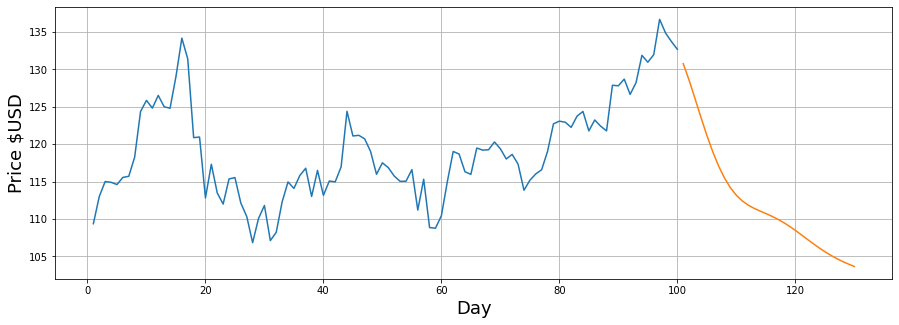

In [71]:
plt.figure(figsize=(15,5))
plt.xlabel('Day', fontsize=18)
plt.ylabel('Price $USD', fontsize=18)
plt.plot(day_new, scaler.inverse_transform(df_close[2165:]))
plt.plot(day_pred,scaler.inverse_transform(list_output))
plt.grid()

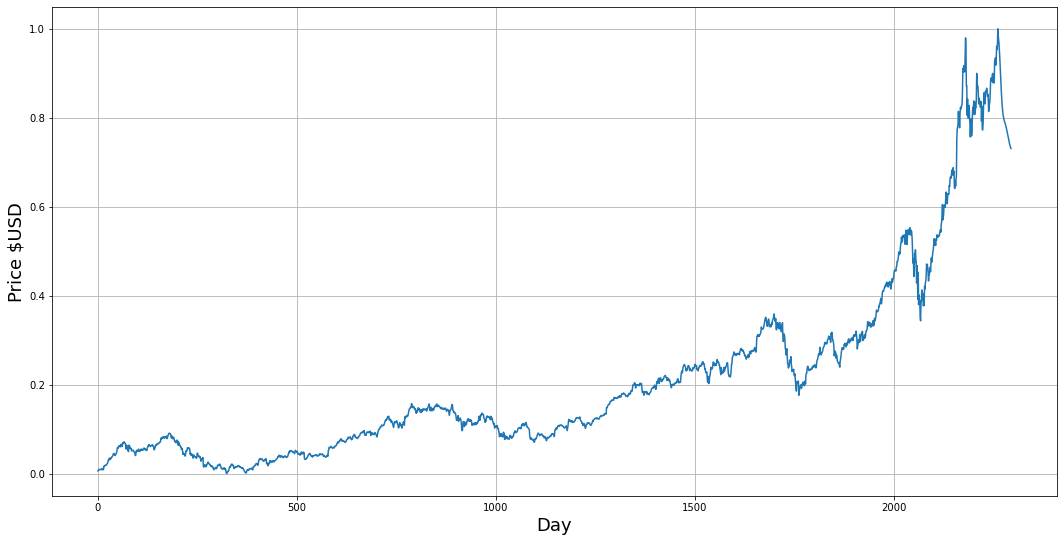

In [80]:
df3 = df_close.tolist()
df3.extend(list_output)
plt.figure(figsize=(18,9))
plt.xlabel('Day', fontsize=18)
plt.ylabel('Price $USD', fontsize=18)
plt.plot(df3)
plt.grid()

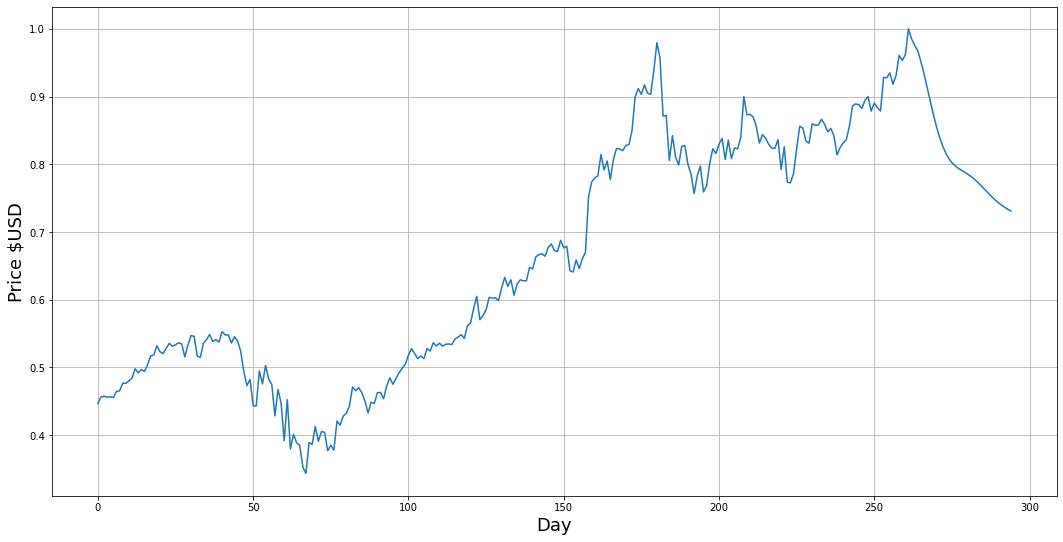

In [82]:
df3 = df_close.tolist()
df3.extend(list_output)
plt.figure(figsize=(18,9))
plt.xlabel('Day', fontsize=18)
plt.ylabel('Price $USD', fontsize=18)
plt.plot(df3[2000:])
plt.grid()